# Home Price Prediction Machine Learning Model (using Zonda data)

Predict home price based on location, brand, square footage, number of bedrooms, number of batchrooms, garage size, and number of stories.  Predictions can then be compared to the actual home price to determine which homes are over and underpriced in their respective markets.  This model can also be used to help determine a price for a new home or exisitng home before it is put on the market.

This notebook demonstrates the following capabilities:

* Reads in CSV data which includes two very large catigory columns which are processed using embedding rather than one hot encoding.
* Encodes category/enumerations putting them in the format needed for training the model.  These include both ordered and unordered categories.
* Trains the model showing a plot of convergence rate allowing for easy adjustment of the learning rate, epochs, and hidden size for best training efficiency and final accuracy.
* Saves the trained model to disk, and later loads back in that model for price predictions.
* Calculates and displays final model accuracy percentage.
* Scatter plots all home actual vs predicted prices as another method of displaying final model accuracy.
* Plots line overlay of all home actual vs predicted prices helping show visually stocks that deviate most from the model’s prediction.
    * This plot is shown twice; once to help show overpriced homes, and once to help show underpriced homes
* Outputs a spreadsheet showing homes including all metrics used to predict the price, both the actual and predicted price, and the percentage difference between those prices denoting how much a home is either overpriced or underpriced.

A Mac M1 Pro using CPU takes around 58 seconds to train this model to a high level of accuracy (~93%).

Also make sure to look at the related notebooks named `housing_growth.ipynb` and `builder_locations.ipynb`

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchviz import make_dot

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

# input_df = pd.read_csv('../inputs/home_sales_zonda.csv', encoding='iso-8859-1')
input_df = pd.read_csv('../inputs/home_sales_zonda.csv')
input_df.head()

,Brand,PlanName,City,State,Zip,ID,Latitude,Longitude,BaseSqFt,Bedrooms,Baths,Garage,Stories,LotSize,SalesRate,BasePrice
0,1034 NE 72nd Street LLC,Plan 1225,Seattle,WA,98115,300069,47.681056,-122.315907,1225.0,2.0,2.0,0.0,3.0,1016.0,1.7,749900.0
1,1034 NE 72nd Street LLC,Plan 1643,Seattle,WA,98115,300067,47.681056,-122.315907,1643.0,3.0,2.5,0.0,3.0,1016.0,1.7,989900.0
2,1034 NE 72nd Street LLC,Plan 1737,Seattle,WA,98115,300068,47.681056,-122.315907,1737.0,3.0,2.5,0.0,3.0,1016.0,1.7,979900.0
3,13th Floor Homes,Amelia,Tamarac,FL,33319,131033,26.192302,-80.211595,1580.0,3.0,2.5,1.0,2.0,3000.0,4.3,332000.0
4,13th Floor Homes,Amelia,West Palm Beach,FL,33404,19032,26.781443,-80.082896,1558.0,3.0,2.5,1.0,2.0,2900.0,3.7,312990.0


In [14]:
# Separate dataframe into features, and target.
target_df = pd.DataFrame({'BasePrice': input_df['BasePrice']})
features_df = input_df.drop(['BasePrice', 'ID', 'PlanName', 'City', 'State', 'Latitude', 'Longitude'], axis=1)
# Brand and Zip are categories but too large to one hot encode them, so instead represent them as embeddings
features_df['Brand'] = pd.Categorical(features_df['Brand']) # Convert string to category
features_df['Zip'] = pd.Categorical(features_df['Zip']) # Convert string to category
num_brand_embeddings = len(features_df['Brand'].cat.categories)
num_zip_embeddings = len(features_df['Zip'].cat.categories)
num_in_features = 7 # Non-embedded features
# Create dictionaries for all embeddings that we can save with the model for use in other application that use the model
brand_dictionary = dict(enumerate(features_df['Brand'].cat.categories))
zip_dictionary = dict(enumerate(features_df['Zip'].cat.categories))
print(f'Dataset size = {features_df.shape[0]}')
print(f'Number of unique brands = {num_brand_embeddings}')
print(f'Number of unique zip codes = {num_zip_embeddings}')
print(f'Number of additional input parameters = {num_in_features}')
print(f'Total input parameters (per home) = {num_brand_embeddings + num_zip_embeddings + num_in_features}')
features_df.head()

Dataset size = 243069
Number of unique brands = 2748
Number of unique zip codes = 4075
Number of additional input parameters = 7
Total input parameters (per home) = 6830


,Brand,Zip,BaseSqFt,Bedrooms,Baths,Garage,Stories,LotSize,SalesRate
0,1034 NE 72nd Street LLC,98115,1225.0,2.0,2.0,0.0,3.0,1016.0,1.7
1,1034 NE 72nd Street LLC,98115,1643.0,3.0,2.5,0.0,3.0,1016.0,1.7
2,1034 NE 72nd Street LLC,98115,1737.0,3.0,2.5,0.0,3.0,1016.0,1.7
3,13th Floor Homes,33319,1580.0,3.0,2.5,1.0,2.0,3000.0,4.3
4,13th Floor Homes,33404,1558.0,3.0,2.5,1.0,2.0,2900.0,3.7


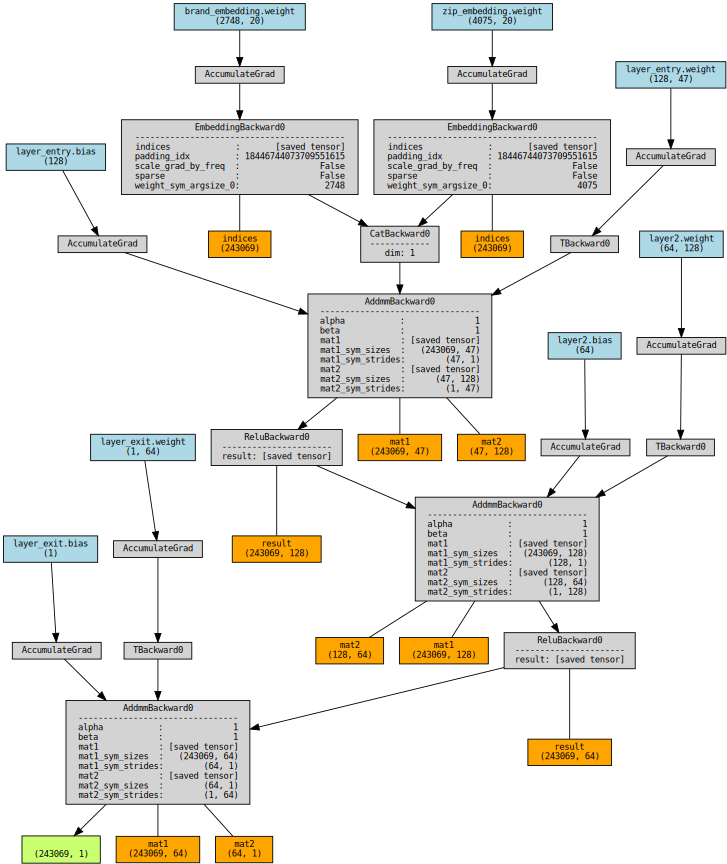

In [16]:
# Convert dataframes to dataset
class MyDataset(Dataset):
    def __init__(self, input_df, target_df):
        self.brand_tensor = torch.tensor(input_df['Brand'].cat.codes.values, dtype=torch.float32).to(device)
        self.zip_tensor = torch.tensor(input_df['Zip'].cat.codes.values, dtype=torch.float32).to(device)
        self.input_tensor = torch.tensor(input_df[['BaseSqFt', 'Bedrooms', 'Baths', 'Garage', 'Stories', 'LotSize', 'SalesRate']].values, dtype=torch.float32).to(device)
        self.target_tensor = torch.tensor(target_df.values, dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.input_tensor) # Number of rows in our input dataset
    def __getitem__(self, idx):
        return self.brand_tensor[idx], self.zip_tensor[idx], self.input_tensor[idx], self.target_tensor[idx]
    def get_tensors(self):
        return self.brand_tensor, self.zip_tensor, self.input_tensor, self.target_tensor

# Define PyTorch model
class MyModel(nn.Module):
    def __init__(self, in_features, num_brand_embeddings, num_zip_embeddings, brand_dictionary, zip_dictionary):
        super(MyModel, self).__init__()
        embedding_dim = 20 # Size of each embedding vector (tunable during training)
        hidden_dim = 64 # Dimensions used for the inner layers of the model
        self.brand_dictionary = brand_dictionary
        self.zip_dictionary = zip_dictionary
        self.brand_embedding = nn.Embedding(num_brand_embeddings, embedding_dim)
        self.zip_embedding = nn.Embedding(num_zip_embeddings, embedding_dim)
        in_features = embedding_dim*2 + in_features
        self.layer_entry = nn.Linear(in_features, hidden_dim*2)
        self.layer2 = nn.Linear(hidden_dim*2, hidden_dim)
        # self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_exit = nn.Linear(hidden_dim, 1)
        
    def forward(self, brand_tensor, zip_tensor, input_tensor):
        brand_tensor = self.brand_embedding(brand_tensor.to(torch.int))
        zip_tensor = self.zip_embedding(zip_tensor.to(torch.int))
        # Concat all tensors after creating embedding vectors, then pass them into the first layer
        x = torch.cat([brand_tensor, zip_tensor, input_tensor], dim=1)
        x = nn.functional.relu(self.layer_entry(x))
        x = nn.functional.relu(self.layer2(x))
        # x = nn.functional.relu(self.layer3(x))
        x = self.layer_exit(x)
        return x

dataset = MyDataset(features_df, target_df)
model = model = MyModel(num_in_features, num_brand_embeddings, num_zip_embeddings, brand_dictionary, zip_dictionary).to(device)
brand_train_tensor, zip_train_tensor, x_train_tensor, target_tensor = dataset.get_tensors()
make_dot(model(brand_train_tensor, zip_train_tensor, x_train_tensor), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [17]:
# Training Tuning Parameters
# 64,0.01,100,MSELoss,Adam = 85.8%
batch_size = 256
learning_rate = 0.01
num_epochs = 400
# Choose the best loss and optimizer functions
criterion = nn.L1Loss().to(device) # MSELoss or L1Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam or SGD
# Split the data and setup the data loaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'Training Size = {train_size}')
print(f'Test Size = {test_size}')

Training Size = 194455
Test Size = 48614


Epoch 20 (5%), Loss: 6866
Epoch 40 (10%), Loss: 3188
Epoch 60 (15%), Loss: 1989
Epoch 80 (20%), Loss: 1404
Epoch 100 (25%), Loss: 1086
Epoch 120 (30%), Loss: 885
Epoch 140 (35%), Loss: 754
Epoch 160 (40%), Loss: 632
Epoch 180 (45%), Loss: 555
Epoch 200 (50%), Loss: 490
Epoch 220 (55%), Loss: 439
Epoch 240 (60%), Loss: 400
Epoch 260 (65%), Loss: 370
Epoch 280 (70%), Loss: 333
Epoch 300 (75%), Loss: 311
Epoch 320 (80%), Loss: 287
Epoch 340 (85%), Loss: 274
Epoch 360 (90%), Loss: 253
Epoch 380 (95%), Loss: 242
Epoch 400 (100%), Loss: 224


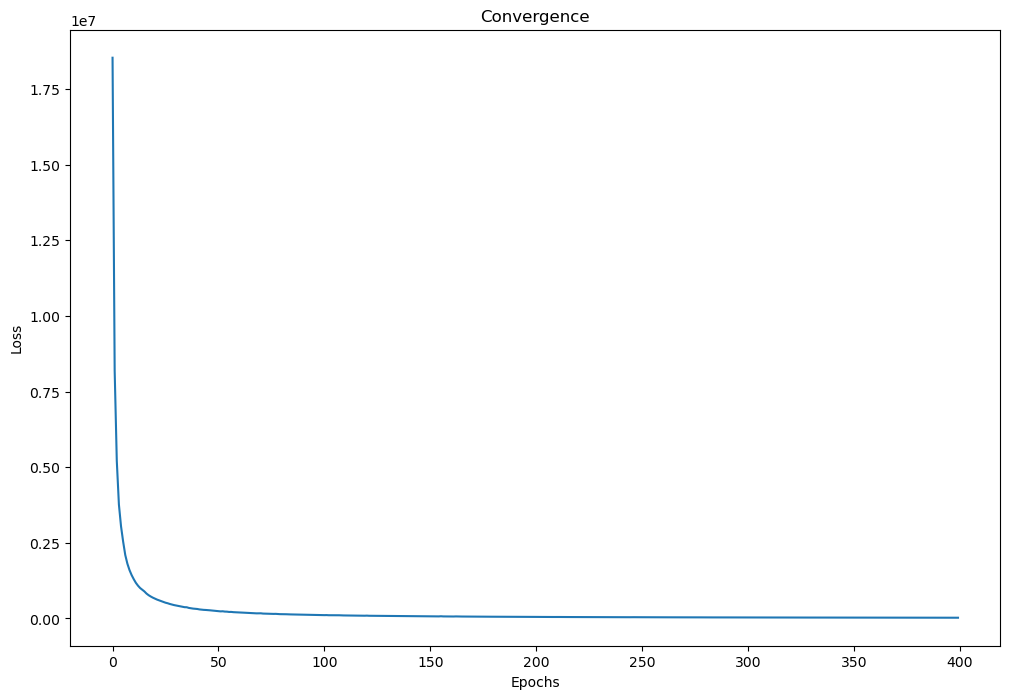

In [18]:
# Train the model and plot convergence
def train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs):
    plot_losses = []
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            brand_tensor, zip_tensor, input_tensor, target_tensor = data
            optimizer.zero_grad()
            output_tensor = model(brand_tensor, zip_tensor, input_tensor)
            loss = criterion(output_tensor, target_tensor)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                brand_tensor, zip_tensor, input_tensor, target_tensor = data
                output_tensor = model(brand_tensor, zip_tensor, input_tensor)
                loss = criterion(output_tensor, target_tensor)
                total_loss += loss.item()
        if epoch % (num_epochs/20) == 0:
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch/100:.0f}') # /100 to simplify display only
        plot_losses.append(total_loss/epoch)
    return plot_losses

# Train the model and plot convergence
plot_losses = train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [19]:
# Save model to file
path = '../api/home_price_model_zonda.pth'
torch.save(model, path)
saved_model = torch.load(path)

def getAccuracyPercentage(list1, list2):
    mean_abs_diff = np.mean(np.abs(list1 - list2))
    mean_orig = np.mean([list1, list2])
    return 100 - mean_abs_diff / mean_orig * 100

# Test the model's accuracy
saved_model.eval()
brand_tensor, zip_tensor, input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(brand_tensor, zip_tensor, input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    accuracy_percent = getAccuracyPercentage(y_predicted, y_actual)
    print(f"Test Accuracy: {accuracy_percent:>0.1f}%")

Test Accuracy: 91.2%


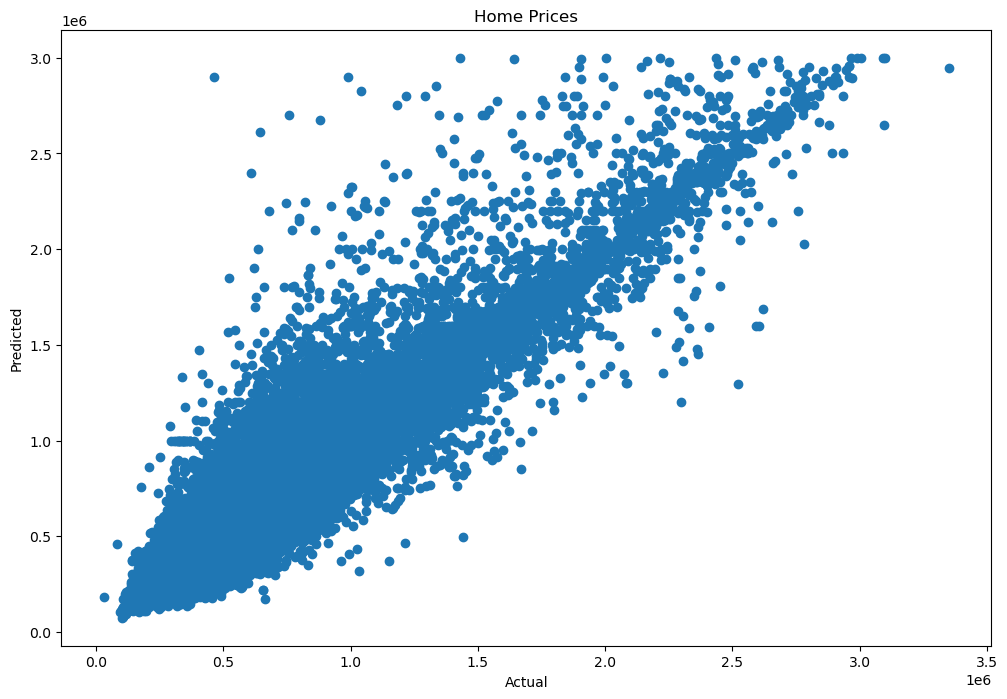

In [20]:
# Scatter plot results to show accuracy (45% upward, rightward slope scatter plot)
plt.figure(figsize=(12,8))
plt.scatter(y_predicted, y_actual)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Home Prices")
plt.show()

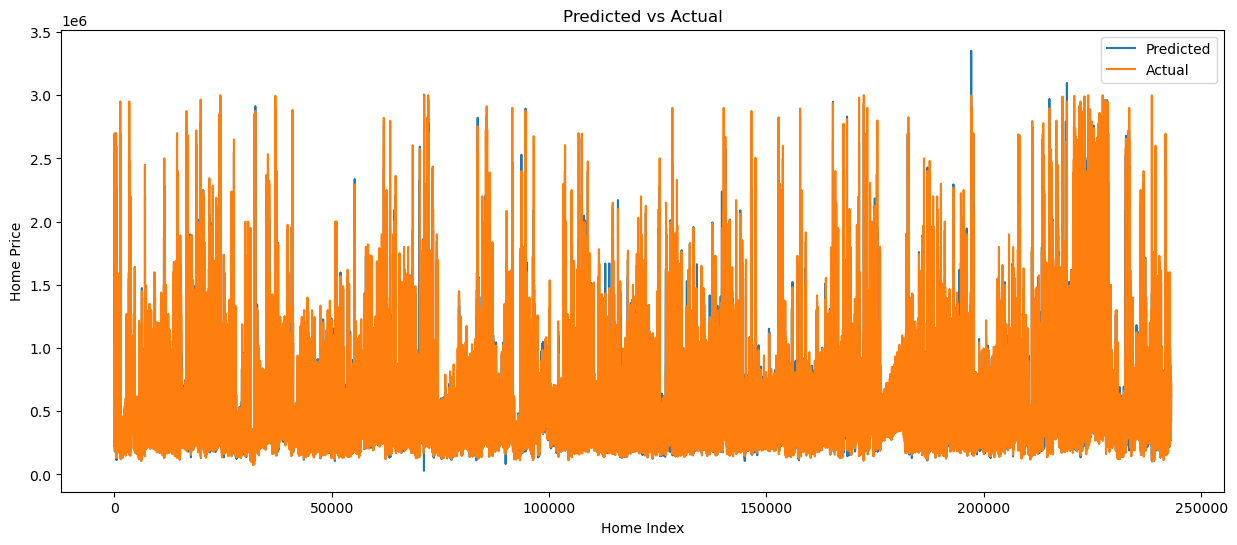

In [21]:
# Show accuracy by overlaying actual vs pridicted prices
# Orange on top helps underpriced stocks stand out
plt.figure(figsize=(15,6))
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.title("Predicted vs Actual")
plt.xlabel("Home Index")
plt.ylabel("Home Price")
plt.legend()
plt.show()

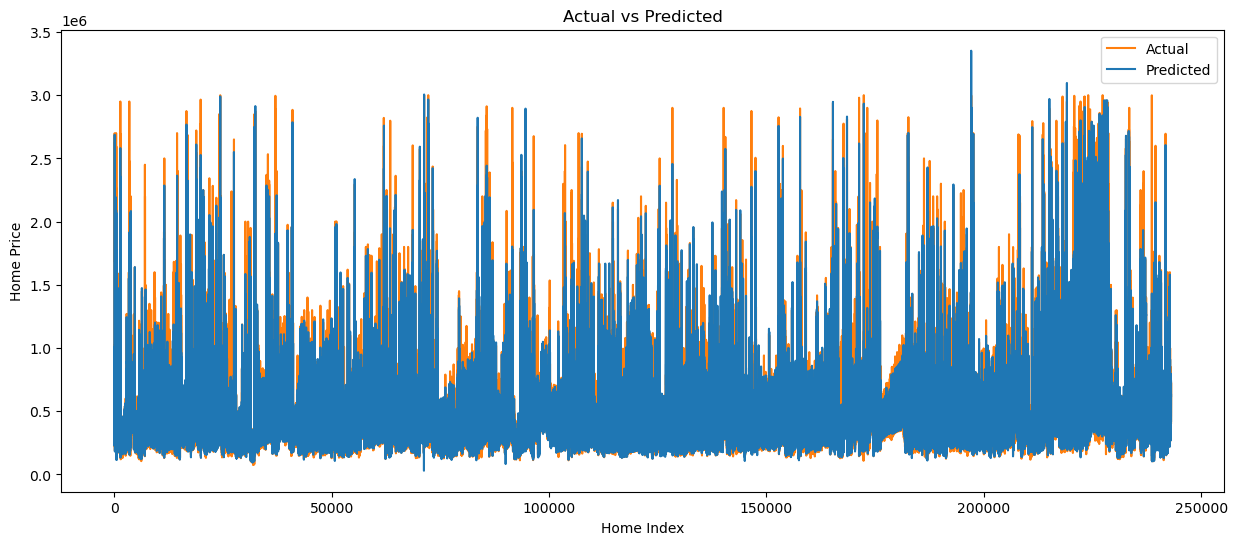

In [22]:
# Inverse the plot so blue is on top.  This helps high overpriced homes stand out
plt.figure(figsize=(15,6))
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.title("Actual vs Predicted")
plt.xlabel("Home Index")
plt.ylabel("Home Price")
plt.legend()
plt.show()

In [23]:
# Run predictions for the full dataset
saved_model.eval()
brand_tensor, zip_tensor, input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(brand_tensor, zip_tensor, input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    predicted_price_difference = (y_predicted - y_actual) / ((y_predicted + y_actual) / 2) * 100
    accuracy_percent = 100-abs(np.average(predicted_price_difference))
# Generate and save to disk a new table with both actual and predicted prices for just those stocks where the prices differ by over 10%
output_df = input_df.copy()
output_df['Predicted Price'] = y_predicted.round()
output_df['% Difference'] = predicted_price_difference
output_df.to_csv('../outputs/home_prices_zonda.csv', index=False)
# Sort so the prices that are too low go to the top
output_df = output_df.sort_values(by='% Difference', ascending=False)
# Homes selling too low
output_df.sample(10, ignore_index=True)

,Brand,PlanName,City,State,Zip,ID,Latitude,Longitude,BaseSqFt,Bedrooms,Baths,Garage,Stories,LotSize,SalesRate,BasePrice,Predicted Price,% Difference
0,Coventry Homes,Design 3341,Allen,TX,75013,60220,33.119105,-96.728087,3106.0,5.0,3.000000,2.0,2.0,7200.0,1.300000,465990.000000,444217.0,-4.784214
1,Smith Douglas Homes,The Carlyle,Lancaster,SC,2972,237008,34.910502,-80.812912,2144.0,3.0,2.500000,2.0,2.0,6000.0,3.700000,232900.000000,199006.0,-15.695145
2,Visionary Homes,Kennison (SOG),Tremonton,UT,84337,278908,41.723599,-112.179614,1500.0,3.0,2.000000,2.0,1.0,6633.0,2.200000,384990.000000,398602.0,3.474234
3,Meritage Homes,The Blanco,Park Row,TX,77493,202729,29.871030,-95.776169,1463.0,3.0,2.000000,2.0,1.0,6000.0,1.200000,228990.000000,260725.0,12.960534
4,SK Builders,Coleman,Greer,SC,29651,90587,35.015458,-82.267877,2217.0,4.0,2.166667,2.0,2.0,34854.0,0.433333,286333.333333,273010.0,-4.763740
5,KB Home,E-2898,Austin,TX,78753,242312,30.394078,-97.650166,2898.0,4.0,2.500000,2.0,2.0,6525.0,4.700000,353555.000000,302656.0,-15.512925
6,Hopper Communities,THE DICKINSON,Round Rock,TX,78664,191715,30.493420,-97.652830,1551.0,3.0,2.500000,2.0,2.0,2584.0,1.300000,202900.000000,208950.0,2.938067
7,CalAtlantic Homes,Plan 5A02,Broomfield,CO,80023,263042,39.995158,-105.020067,2393.0,3.0,3.500000,3.0,1.0,6900.0,1.700000,659900.000000,627840.0,-4.979227
8,Tuskes Homes,Alston Traditional,Easton,PA,18045,102460,40.693475,-75.272529,2480.0,3.0,2.500000,2.0,2.0,12312.5,1.850000,435400.000000,468445.0,7.312115
9,Century Communities,EMORY - 1948,San Antonio,TX,78224,398803,29.319088,-98.564374,1948.0,3.0,3.500000,2.0,1.0,4800.0,4.150000,305990.000000,308648.0,0.864920


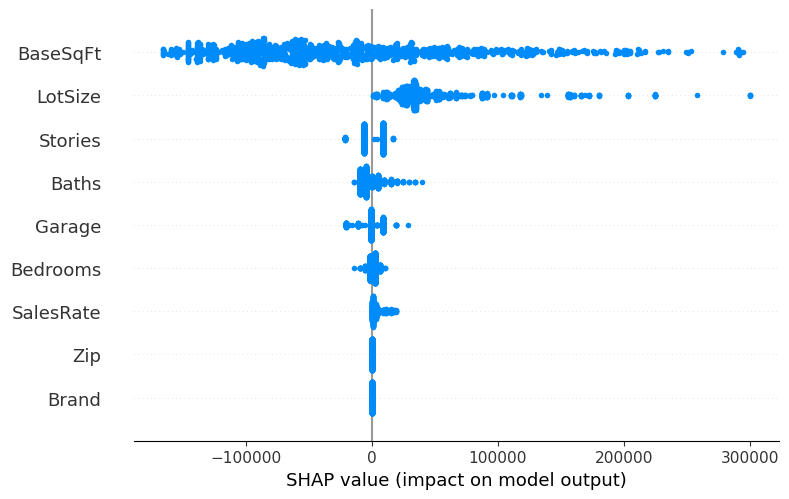

In [25]:
import shap

shap_length = 1000 # Reduce the size of the tensor so explanation does not take too long
X = [brand_tensor[:shap_length], zip_tensor[:shap_length], input_tensor[:shap_length, :]]
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)
feature_names = list(features_df.columns)
# shap.summary_plot(shap_values[-1], input_tensor[:shap_length, :], feature_names=feature_names[-5:]) # This has colors for high/low, but does not include brand or zip
shap_brand = shap_values[0].reshape(-1, 1)
shap_zip = shap_values[1].reshape(-1, 1)
shap_input = np.concatenate([shap_values[2], np.zeros((len(shap_values[0]) - len(shap_values[2]), 7))], axis=0)
shap_values_matrix = np.concatenate([shap_brand, shap_zip, shap_input], axis=1)
shap.summary_plot(shap_values_matrix, X, feature_names=feature_names)